In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
os.listdir('drive/My Drive/Fantasy football')

['FantasyPros_Fantasy_Football_Statistics_WR.csv',
 'FantasyPros_Fantasy_Football_Statistics_RB.csv',
 'WR_adv.csv',
 'RB_adv.csv']

In [ ]:
d_wr = pd.read_csv('drive/My Drive/Fantasy football/FantasyPros_Fantasy_Football_Statistics_WR.csv')
d_wr = d_wr.loc[:, ['Player', 'FPTS', 'FPTS/G']]
_d = pd.read_csv('drive/My Drive/Fantasy football/WR_adv.csv')
d_wr = d_wr.dropna()
_d = _d.dropna()

In [ ]:
d_wr = d_wr.merge(_d, on = 'Player')

In [ ]:
d_wr.head()

,Player,FPTS,FPTS/G,Rank,G,REC,YDS,Y/R,YBC,YBC/R,...,% TM,CATCHABLE,DROP,RZ TGT,10+ YDS,20+ YDS,30+ YDS,40+ YDS,50+ YDS,LNG
0,Justin Jefferson (MIN),240.6,14.2,1.0,17.0,128.0,"1,809",14.1,"1,185",9.3,...,28.7%,134.0,5.0,28.0,74.0,28.0,14.0,6.0,1.0,64.0
1,Davante Adams (LV),235.5,13.9,2.0,17.0,100.0,"1,516",15.2,"1,023",10.2,...,32.3%,109.0,8.0,22.0,61.0,24.0,14.0,7.0,2.0,60.0
2,Tyreek Hill (MIA),222.2,13.1,3.0,17.0,119.0,"1,710",14.4,"1,226",10.3,...,30.2%,127.0,8.0,9.0,69.0,25.0,9.0,7.0,4.0,64.0
3,A.J. Brown (PHI),211.6,12.4,4.0,17.0,88.0,"1,496",17.0,953,10.8,...,28.7%,95.0,6.0,16.0,58.0,23.0,13.0,6.0,3.0,78.0
4,Stefon Diggs (BUF),211.2,12.4,5.0,17.0,110.0,"1,455",13.2,"1,023",9.3,...,28.1%,117.0,7.0,23.0,57.0,17.0,10.0,6.0,2.0,53.0


In [ ]:
d_wr.dtypes

Player        object
FPTS         float64
FPTS/G       float64
Rank         float64
G            float64
REC          float64
YDS           object
Y/R          float64
YBC           object
YBC/R        float64
AIR           object
AIR/R        float64
YAC          float64
YAC/R        float64
YACON        float64
YACON/R      float64
BRKTKL       float64
TGT          float64
% TM          object
CATCHABLE    float64
DROP         float64
RZ TGT       float64
10+ YDS      float64
20+ YDS      float64
30+ YDS      float64
40+ YDS      float64
50+ YDS      float64
LNG          float64
dtype: object

In [ ]:
d_wr['% TM'] = d_wr["% TM"].str.replace("%","")
d_wr['% TM'] = d_wr['% TM'].astype(float)

In [ ]:
d_wr.columns

Index(['Player', 'FPTS', 'FPTS/G', 'Rank', 'G', 'REC', 'YDS', 'Y/R', 'YBC',
       'YBC/R', 'AIR', 'AIR/R', 'YAC', 'YAC/R', 'YACON', 'YACON/R', 'BRKTKL',
       'TGT', '% TM', 'CATCHABLE', 'DROP', 'RZ TGT', '10+ YDS', '20+ YDS',
       '30+ YDS', '40+ YDS', '50+ YDS', 'LNG'],
      dtype='object')

In [ ]:
d_wr['BRKTKL/REC']= d_wr['BRKTKL']/d_wr['REC']
d_wr['TGT/G'] = d_wr['TGT']/ d_wr['G']
d_wr['RZ_TGT/G'] = d_wr['RZ TGT']/ d_wr['G']
d_wr['CATCHABLE/G'] = d_wr['CATCHABLE']/ d_wr['G']
d_wr['DROPS/G'] = d_wr['DROP']/ d_wr['G']

In [ ]:
d_wr_reg = d_wr.loc[d_wr['TGT'] > 60, ['Player', 'Y/R', 'TGT/G', 'AIR/R', 'YAC/R', 'YACON/R', 'BRKTKL/REC', '% TM',
                                       'RZ_TGT/G', 'CATCHABLE/G', 'DROPS/G', 'FPTS/G']]

In [ ]:
d_wr_reg.shape
d_wr_reg = d_wr_reg.reset_index()

In [ ]:
features = ['YAC/R', 'AIR/R', '% TM', 'RZ_TGT/G', 'CATCHABLE/G', 'DROPS/G']
target = 'FPTS/G'
kf = KFold(5, shuffle=True, random_state=1)

# create empty out-of-sample pd.Series
oos_preds = pd.Series(dtype=float)

for train_index, test_index in kf.split(d_wr_reg):
  train = d_wr_reg.loc[train_index]
  test = d_wr_reg.loc[test_index]

  # initialize, train, and predict
  model = LinearRegression()
  model.fit(train.loc[:, features], train[target])
  test[f"{target}_pred"] = model.predict(test.loc[:, features])

  # concatenate new preds to oos Series
  oos_preds = pd.concat([oos_preds, test[f'{target}_pred']])

d_wr_reg[f'{target}_pred'] = oos_preds

In [ ]:
d_wr_reg = d_wr_reg.sort_values(by=['FPTS/G_pred'], ascending = False)
d_wr_reg['diff'] = d_wr_reg['FPTS/G_pred'] - d_wr_reg['FPTS/G']
d_wr_reg.sort_values(by=['FPTS/G_pred'], ascending = False).head(20)

,index,Player,Y/R,TGT/G,AIR/R,YAC/R,YACON/R,BRKTKL/REC,% TM,RZ_TGT/G,CATCHABLE/G,DROPS/G,FPTS/G,FPTS/G_pred,diff
0,0,Justin Jefferson (MIN),14.1,10.823529,9.3,4.9,1.0,0.046875,28.7,1.647059,7.882353,0.294118,14.2,13.636939,-0.563061
21,21,Cooper Kupp (LAR),10.8,10.888889,5.2,5.7,1.4,0.040000,19.0,1.222222,8.777778,0.222222,14.0,12.693692,-1.306308
2,2,Tyreek Hill (MIA),14.4,10.000000,10.3,4.1,0.5,0.042017,30.2,0.529412,7.470588,0.470588,13.1,12.337026,-0.762974
1,1,Davante Adams (LV),15.2,10.588235,10.2,4.9,1.0,0.090000,32.3,1.294118,6.411765,0.470588,13.9,12.084927,-1.815073
11,11,Ja'Marr Chase (CIN),12.0,10.307692,7.0,5.0,1.6,0.114943,22.4,1.846154,7.615385,0.769231,12.0,11.983997,-0.016003
3,3,A.J. Brown (PHI),17.0,8.529412,10.8,6.2,2.2,0.079545,28.7,0.941176,5.588235,0.352941,12.4,11.454389,-0.945611
4,4,Stefon Diggs (BUF),13.2,9.176471,9.3,3.9,0.9,0.018182,28.1,1.352941,6.882353,0.411765,12.4,11.343648,-1.056352
6,6,Jaylen Waddle (MIA),18.1,6.882353,11.2,6.9,2.0,0.053333,20.8,0.470588,4.823529,0.411765,10.8,10.895179,0.095179
48,48,DeAndre Hopkins (TEN),11.2,10.666667,8.6,2.6,0.9,0.015625,15.1,0.666667,7.666667,0.555556,9.7,10.773701,1.073701
5,5,CeeDee Lamb (DAL),12.6,9.176471,8.0,4.6,1.4,0.093458,28.6,0.705882,6.705882,0.352941,11.4,10.608106,-0.791894


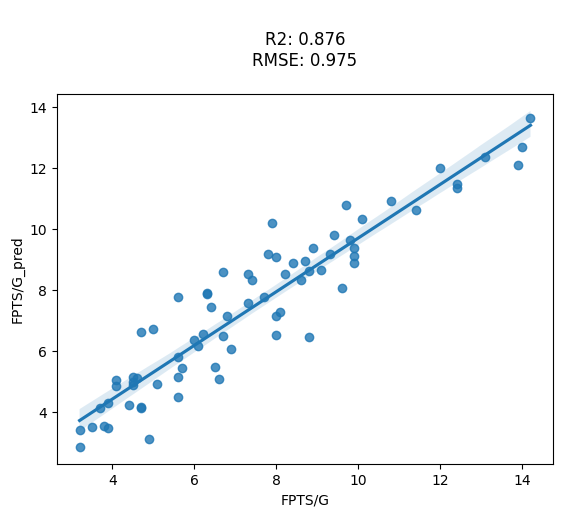

In [ ]:
r2 = pearsonr(d_wr_reg[target], d_wr_reg[f"{target}_pred"])[0]**2
rmse = mean_squared_error(d_wr_reg[target], d_wr_reg[f"{target}_pred"])**0.5
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""

sns.regplot(data = d_wr_reg, x=target, y=f"{target}_pred")
plt.title(title_str)
plt.show()

In [ ]:
d_rb = pd.read_csv('drive/My Drive/Fantasy football/FantasyPros_Fantasy_Football_Statistics_RB.csv')
d_rb = d_rb.loc[:, ['Player', 'FPTS', 'FPTS/G']]
_d = pd.read_csv('drive/My Drive/Fantasy football/RB_adv.csv')
d_rb = d_rb.dropna()
_d = _d.dropna()
d_rb = d_rb.merge(_d)

In [ ]:
d_rb.columns

Index(['Player', 'FPTS', 'FPTS/G', 'Rank', 'G', 'ATT', 'YDS', 'Y/ATT', 'YBCON',
       'YBCON/ATT', 'YACON', 'YACON/ATT', 'BRKTKL', 'TK LOSS', 'TK LOSS YDS',
       'LNG TD', '10+ YDS', '20+ YDS', '30+ YDS', '40+ YDS', '50+ YDS', 'LNG',
       'REC', 'TGT', 'RZ TGT', 'YACON.1'],
      dtype='object')

In [ ]:
d_rb['ATT/G'] = d_rb['ATT']/ d_rb['G']
d_rb['Lyards/ATT'] = d_rb['TK LOSS YDS']/ d_rb['ATT']
d_rb['BRKTKL/ATT'] = d_rb['BRKTKL']/ d_rb['ATT']
d_rb['TGT/G'] = d_rb['TGT']/d_rb['G']
d_rb['RZ_TGT/G'] = d_rb['RZ TGT']/d_rb['G']

In [ ]:
d_rb_reg = d_rb.loc[d_rb['ATT'] > 100, ['Player', 'ATT/G', 'Y/ATT', 'YACON/ATT',
                                        'Lyards/ATT', 'BRKTKL/ATT', 'TGT/G', 'RZ_TGT/G', 'FPTS/G']]

In [ ]:
d_rb_reg.tail()
d_rb_reg = d_rb_reg.reset_index()

In [ ]:
features = ['ATT/G', 'Y/ATT', 'YACON/ATT', 'Lyards/ATT', 'BRKTKL/ATT', 'TGT/G', 'RZ_TGT/G']
target = 'FPTS/G'
kf = KFold(5, shuffle=True, random_state=1)

# create empty out-of-sample pd.Series
oos_preds = pd.Series(dtype=float)

for train_index, test_index in kf.split(d_rb_reg):
  train = d_rb_reg.loc[train_index]
  test = d_rb_reg.loc[test_index]

  # initialize, train, and predict
  model = LinearRegression()
  model.fit(train.loc[:, features], train[target])
  test[f"{target}_pred"] = model.predict(test.loc[:, features])

  # concatenate new preds to oos Series
  oos_preds = pd.concat([oos_preds, test[f'{target}_pred']])

d_rb_reg[f'{target}_pred'] = oos_preds

In [ ]:
d_rb_reg = d_rb_reg.sort_values(by=['FPTS/G_pred'], ascending = False)
d_rb_reg['diff'] = d_rb_reg['FPTS/G_pred'] - d_rb_reg['FPTS/G']
d_rb_reg.sort_values(by=['diff'], ascending = False).head(40)

,index,Player,ATT/G,Y/ATT,YACON/ATT,Lyards/ATT,BRKTKL/ATT,TGT/G,RZ_TGT/G,FPTS/G,FPTS/G_pred,diff
17,17,Alvin Kamara (NO),14.866667,4.0,2.0,-0.147982,0.031390,5.133333,0.733333,10.3,13.577295,3.277295
35,38,Brian Robinson Jr. (WAS),17.083333,3.9,1.7,-0.092683,0.039024,1.000000,0.083333,8.6,11.866316,3.266316
26,28,Dameon Pierce (HOU),16.923077,4.3,2.3,-0.277273,0.122727,3.000000,0.153846,10.5,12.023204,1.523204
33,35,Jonathan Taylor (IND),16.000000,4.5,2.0,-0.156250,0.125000,3.333333,0.250000,9.9,11.420074,1.520074
10,10,Aaron Jones (GB),12.529412,5.3,2.2,-0.267606,0.061033,4.235294,0.529412,11.2,12.694322,1.494322
5,5,Saquon Barkley (NYG),18.437500,4.4,1.9,-0.261017,0.040678,4.750000,0.125000,14.2,15.678990,1.478990
8,8,Dalvin Cook (NYJ),15.529412,4.4,1.8,-0.246212,0.045455,3.294118,0.588235,11.7,13.061072,1.361072
15,15,Travis Etienne Jr. (JAC),12.941176,5.1,1.8,-0.259091,0.063636,2.647059,0.294118,10.0,11.123991,1.123991
21,21,Tyler Allgeier (ATL),13.125000,4.9,2.0,-0.114286,0.023810,1.062500,0.000000,9.0,9.936548,0.936548
41,48,Damien Harris (BUF),9.636364,4.4,1.5,-0.179245,0.047170,2.090909,0.545455,6.7,7.590205,0.890205


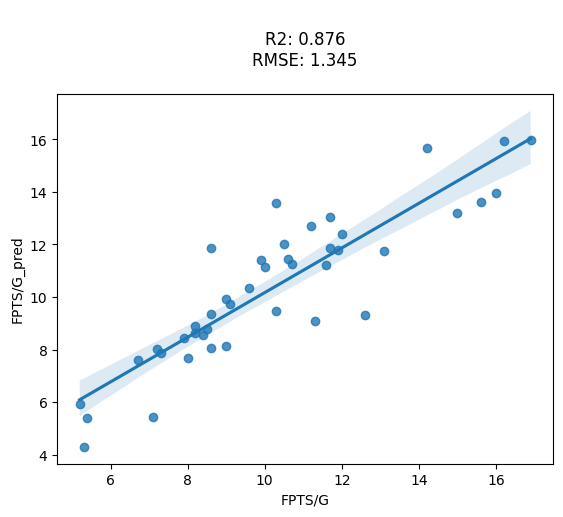

In [ ]:
d_rbr2 = pearsonr(d_rb_reg[target], d_rb_reg[f"{target}_pred"])[0]**2
rmse = mean_squared_error(d_rb_reg[target], d_rb_reg[f"{target}_pred"])**0.5
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""

sns.regplot(data = d_rb_reg, x=target, y=f"{target}_pred")
plt.title(title_str)
plt.show()